In [1]:
import tensorflow as tf
from tensorflow import keras 
from skimage import color
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:

dataset = np.load('/Users/mac/Dev/Project/ThermalCamera/Model/Custom/model/detection_dataset.npz')


origin_images, target_images, number_labels, coordinates = dataset['images'], dataset['filters'], dataset['numbers'],  dataset['coordinates']


print(origin_images.shape)
print(target_images.shape)
print(number_labels.shape)
print(coordinates.shape)


(2203, 24, 32)
(2203, 24, 32)
(2203,)
(2203, 4, 8)


In [3]:
origin_images = origin_images.reshape(2203, 24, 32, 1)
target_images = target_images.reshape(2203, 24, 32, 1)
print(origin_images.shape)
print(target_images.shape)

(2203, 24, 32, 1)
(2203, 24, 32, 1)


In [4]:
print(origin_images.max(), origin_images.min())
print(target_images.max(), target_images.min())

origin_images = origin_images / origin_images.max()
target_images = target_images / target_images.max()

print(origin_images.max(), origin_images.min())
print(target_images.max(), target_images.min())

255 0
255 0
1.0 0.0
1.0 0.0


In [5]:
def normalize_coordinates(coords, width=32, height=24):
    # Check the shape of the input coordinates
    if coords.shape[-1] != 8:
        raise ValueError("The last dimension of the input coordinates should be 8.")

    # Create a normalization array
    normalization_factors = np.array([width, height, width, height, width, height, width, height])

    # Normalize the coordinates
    normalized_coords = coords / normalization_factors

    return normalized_coords


In [6]:
norm_location = normalize_coordinates(coordinates)
print(norm_location.shape)

from keras.utils import to_categorical

trian_labels = to_categorical(number_labels, num_classes=5)

(2203, 4, 8)


(5, 48, 32, 1)


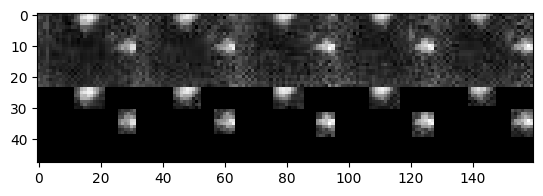

[2 2 2 2 2]
[[[0.375      0.         0.65625    0.         0.65625    0.25
   0.375      0.25      ]
  [0.8125     0.29166667 1.         0.29166667 1.         0.58333333
   0.8125     0.58333333]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]]

 [[0.375      0.         0.625      0.         0.625      0.25
   0.375      0.25      ]
  [0.78125    0.29166667 1.         0.29166667 1.         0.58333333
   0.78125    0.58333333]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]]

 [[0.375      0.         0.65625    0.         0.65625    0.25
   0.375      0.25      ]
  [0.8125     0.33333333 1.         0.33333333 1.         0.625
   0.8125     0.625     ]
  [0.         0.         0.         0.         0.         0.
   0.         0.        ]
  

In [7]:
imgs = np.concatenate([origin_images[1000:1005], target_images[1000:1005]], axis = 1)
print(imgs.shape)

plt.imshow(imgs.transpose(1, 0, 2, 3).reshape(48, -1, 1), cmap = 'gray')
plt.show()
print(number_labels[1000:1005])

print(norm_location[1000:1005])

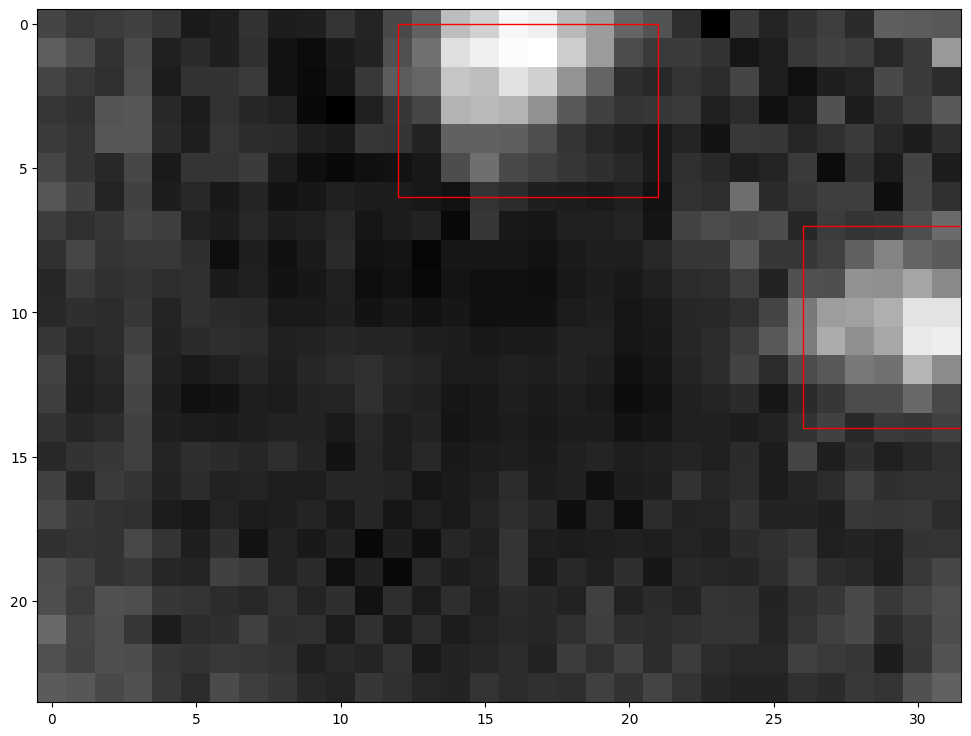

In [47]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_boxes_on_image(image, normalized_coords, width=32, height=24):

    # Remove the first dimension from normalized_coords
    normalized_coords = normalized_coords.squeeze()

    # Denormalize the coordinates
    denormalized_coords = normalized_coords * [width, height, width, height, width, height, width, height]

    if image.ndim == 4:
        image = image[0]

    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 9))
    
    # Display the image
    ax.imshow(image[:, :, 0], cmap='gray')

    # Loop over each set of coordinates and draw the bounding box
    for coord in denormalized_coords:
        # Extract coordinates for the bounding box
        top_left_x, top_left_y, top_right_x, top_right_y, bottom_right_x, bottom_right_y, bottom_left_x, bottom_left_y = coord
        
        # Create a rectangle patch using top left and bottom right coordinates
        rect = patches.Rectangle((top_left_x, top_left_y), bottom_right_x - top_left_x, bottom_right_y - top_left_y, linewidth=1, edgecolor='r', facecolor='none')
        
        # Add the patch to the axis
        ax.add_patch(rect)

    plt.show()





draw_boxes_on_image(origin_images[1000:1001], norm_location[1000:1001])


In [9]:
from keras.layers import Dense, Input, MaxPool2D, Conv2D, Conv2DTranspose, Flatten, Reshape, Activation
from keras.layers import BatchNormalization, Dropout, Activation, concatenate
from keras.models import Model

def SupervisedAutoEncoder():
    # 이미지 입력
    inputs_image = Input(shape=(24, 32, 1))

    # Encoder 부분
    e1 = Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(inputs_image)
    e2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(e1)
    e3 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(e2)
    e4 = Flatten()(e3)
    latent_vector = Dense(units = 32)(e4)

    # Decoder 부분 (이미지 재구성)
    x = Dense(3 * 4 * 128)(latent_vector)
    x = Reshape(target_shape=(3, 4, 128))(x)
    d1 = Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    d2 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(d1)
    d3 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')(d2)
    reconstructed_image = Conv2DTranspose(filters=1, kernel_size=3, padding='same', activation='sigmoid')(d3)
    
    # 추가적인 출력 계층 (좌표 예측)
    # rec_img = Flatten()(c3)
    coords_output = Dense(4*8, activation='tanh')(latent_vector)  # 좌표값이 8개라고 가정
    coords_output = Reshape((4, 8))(coords_output)  # 출력의 형태를 [batch_size, 4, 8]로 변환

    return Model(inputs_image, [reconstructed_image, coords_output])

In [10]:
supervised_autoEncoder = SupervisedAutoEncoder()
supervised_autoEncoder.summary()

2023-11-02 16:12:31.741830: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-11-02 16:12:31.741857: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-11-02 16:12:31.741862: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-11-02 16:12:31.741899: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-11-02 16:12:31.741916: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 12, 16, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 6, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 3, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                              

In [11]:
supervised_autoEncoder.compile(optimizer='adam', 
              loss=['mse', 'mse'], 
              loss_weights=[1, 0.1],
              metrics = ['accuracy']
              )  # 재구성 손실과 좌표 손실을 조절하기 위해 loss_weights 사용

hist = supervised_autoEncoder.fit(
    origin_images, [target_images, norm_location], 
    epochs=50,
    verbose = 1
)

Epoch 1/50


2023-11-02 16:12:32.636024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 2s 21ms/step - loss: 0.0674 - conv2d_transpose_3_loss: 0.0548 - reshape_1_loss: 0.1258 - conv2d_transpose_3_accuracy: 0.8307 - reshape_1_accuracy: 0.2007
Epoch 2/50
69/69 [==============================] - 1s 17ms/step - loss: 0.0280 - conv2d_transpose_3_loss: 0.0244 - reshape_1_loss: 0.0364 - conv2d_transpose_3_accuracy: 0.8341 - reshape_1_accuracy: 0.1919
Epoch 3/50
69/69 [==============================] - 1s 17ms/step - loss: 0.0176 - conv2d_transpose_3_loss: 0.0148 - reshape_1_loss: 0.0283 - conv2d_transpose_3_accuracy: 0.8341 - reshape_1_accuracy: 0.2229
Epoch 4/50
69/69 [==============================] - 1s 17ms/step - loss: 0.0105 - conv2d_transpose_3_loss: 0.0082 - reshape_1_loss: 0.0232 - conv2d_transpose_3_accuracy: 0.8341 - reshape_1_accuracy: 0.1885
Epoch 5/50
69/69 [==============================] - 1s 18ms/step - loss: 0.0079 - conv2d_transpose_3_loss: 0.0058 - reshape_1_loss: 0.0207 - conv2d_transpose_3_accuracy: 0.8342 - reshape_

1/1 [==============================] - 0s 17ms/step


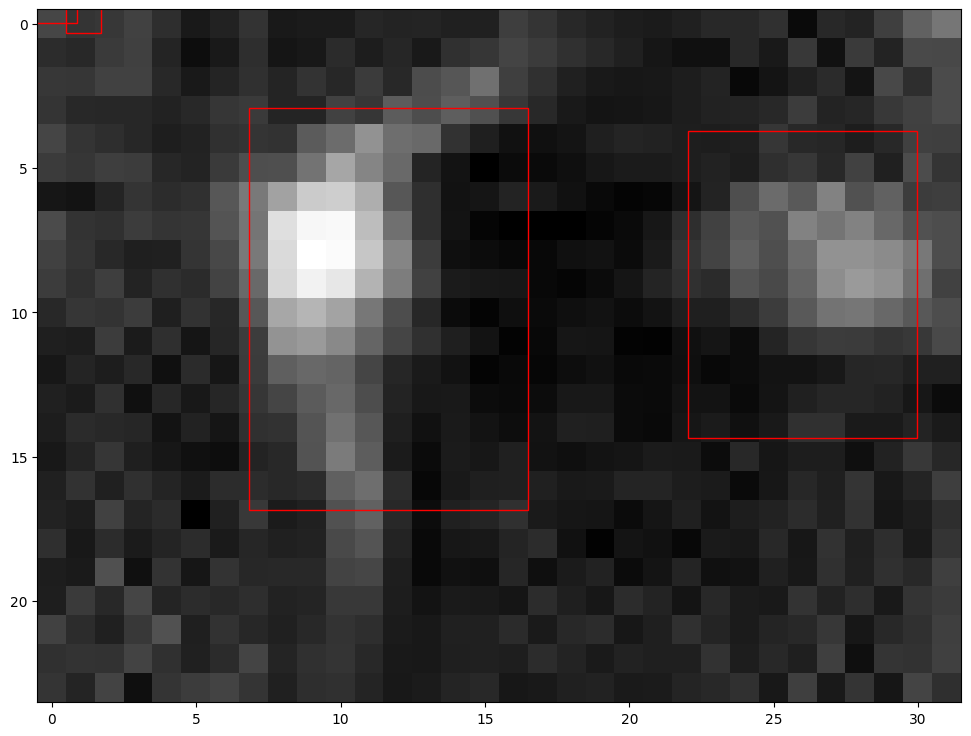

In [48]:
res = supervised_autoEncoder.predict(origin_images[110:111])
# images = np.concatenate([origin_images[110:115],  target_images[110:115], res[0][:6]], axis = 1).transpose(1, 0, 2, 3).reshape(72, -1, 1)

# plt.imshow(images, cmap='gray')
# plt.show()

# print(res[1][:6])
# print(res[1][:6])

draw_boxes_on_image(origin_images[110:111], res[1][:])

In [13]:
from keras.layers import GRU, Dense, Input, Conv2D, Reshape
from keras.models import Model

def Sequence():
    supervised_autoEncoder.trainable = False
    reconstruction_input = supervised_autoEncoder.layers[-2].output
    coords_input = supervised_autoEncoder.layers[-1].output

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(reconstruction_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), strides=(4, 4), activation='relu', padding='same')(x) 

    x = Reshape((6, 8*64))(x)  # 6x(8*64) 형태로 변환

    # coords_input의 정보를 압축하고 적절한 형태로 변환
    compressed_coords = Dense(6*8, activation='relu')(Flatten()(coords_input))
    reshaped_coords = Reshape((6, 8))(compressed_coords)
    
    x = concatenate([x, reshaped_coords], axis=-1)

    # GRU 계층
    x = GRU(64, return_sequences=True)(x)
    x = GRU(64)(x)

    # 사람 수 예측 계층
    number_output = Dense(5, activation='softmax', name='number_output')(x)

    # 좌표값 예측 계층 (32개의 값을 예측합니다. 4명 * 8개의 좌표값)
    coords_output = Dense(4*8, activation='tanh', name='coords_output')(x)
    coords_output =  Reshape((4, 8))(coords_output)


    sequence_model = Model(inputs=supervised_autoEncoder.input, outputs=[number_output, coords_output])
    return sequence_model

In [2]:
class 나는_클래스이다:
    def 나는_함수이다():
        print("나는 함수이다.")

나는_클래스이다.나는_함수이다()

나는 함수이다.


In [14]:
model = Sequence()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 24, 32, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 12, 16, 32)           320       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 6, 8, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 3, 4, 128)            73856     ['conv2d_1[0][0]']            
                                                                                            

In [15]:
model.compile(optimizer='adam', 
              loss=['categorical_crossentropy', 'mse'], 
              loss_weights=[1, 0.1],
              metrics = ['accuracy']
              )  # 재구성 손실과 좌표 손실을 조절하기 위해 loss_weights 사용

hist = model.fit(
    origin_images, [trian_labels, norm_location], 
    epochs=50,
    verbose = 1
)

Epoch 1/50


2023-11-02 16:13:34.713237: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 16:13:35.079898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 16:13:35.140966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 16:13:35.334681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-11-02 16:13:35.456382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


69/69 [==============================] - 5s 34ms/step - loss: 0.6259 - number_output_loss: 0.6161 - reshape_4_loss: 0.0977 - number_output_accuracy: 0.7626 - reshape_4_accuracy: 0.1521
Epoch 2/50
69/69 [==============================] - 2s 29ms/step - loss: 0.1328 - number_output_loss: 0.1305 - reshape_4_loss: 0.0228 - number_output_accuracy: 0.9750 - reshape_4_accuracy: 0.2526
Epoch 3/50
69/69 [==============================] - 2s 29ms/step - loss: 0.0173 - number_output_loss: 0.0155 - reshape_4_loss: 0.0183 - number_output_accuracy: 0.9977 - reshape_4_accuracy: 0.2738
Epoch 4/50
69/69 [==============================] - 2s 29ms/step - loss: 0.0104 - number_output_loss: 0.0087 - reshape_4_loss: 0.0174 - number_output_accuracy: 0.9977 - reshape_4_accuracy: 0.2619
Epoch 5/50
69/69 [==============================] - 2s 30ms/step - loss: 0.0087 - number_output_loss: 0.0072 - reshape_4_loss: 0.0152 - number_output_accuracy: 0.9982 - reshape_4_accuracy: 0.2981
Epoch 6/50
69/69 [=============

1/1 [==============================] - 0s 20ms/step


2


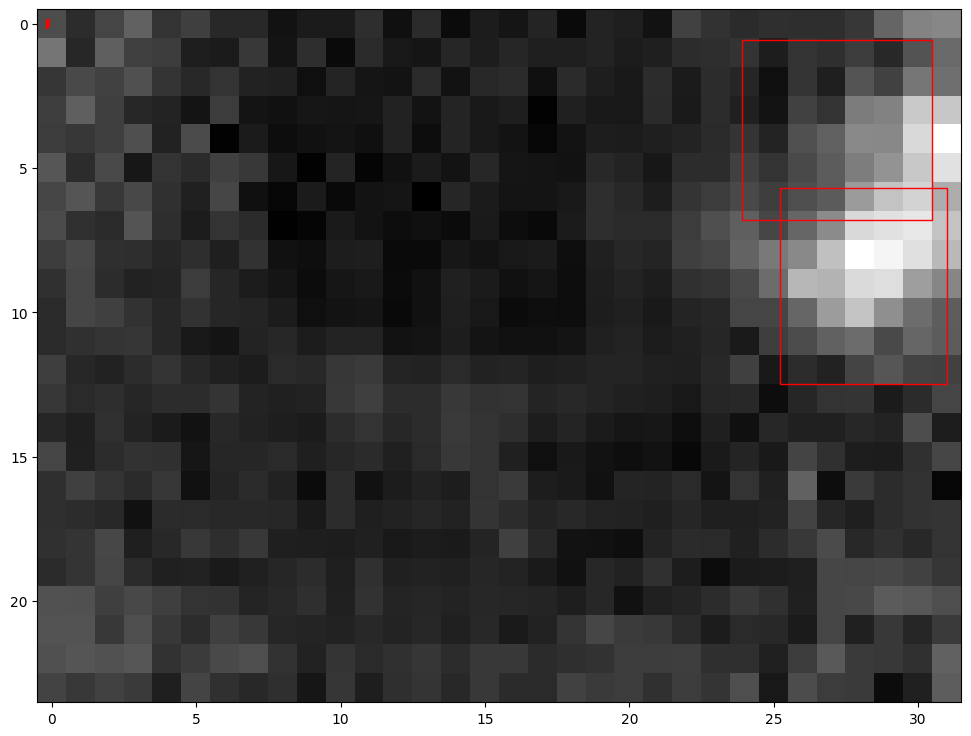

In [49]:
res = model.predict(origin_images[2000:2001])
# print(origin_images[2000:2001].shape)
# images = np.concatenate([origin_images[110:115],  target_images[110:115], res[0][:6]], axis = 1).transpose(1, 0, 2, 3).reshape(72, -1, 1)

# plt.imshow(images, cmap='gray')
# plt.show()

# print(res[1][:6])
# print(res[1][:6])

print(res[0].argmax())
draw_boxes_on_image(origin_images[2000:2001], res[1][:])


In [82]:
import os
import re
import cv2
import numpy as np

def extract_number(filename):
    match = re.search(r'(\d+)_png', filename)
    if match:
        return int(match.group(1))
    return None

def make_video_from_images(image_folder, video_name, fps=10.0):
    # 이미지 폴더 내의 모든 파일들을 가져옵니다.
    images = [img for img in os.listdir(image_folder) if img.endswith(".png") or img.endswith(".jpg")]

    # 숫자 기준으로 이미지들을 정렬합니다.
    images.sort(key=extract_number)

    # 첫 번째 이미지를 통해 프레임의 너비와 높이를 가져옵니다.
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    h, w, layers = frame.shape
    size = (w, h)

    # VideoWriter 객체를 초기화합니다.
    out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), fps, size)

    # 이미지들을 하나씩 동영상에 추가합니다.
    for image in images:
        img_path = os.path.join(image_folder, image)
        img = cv2.imread(img_path)
        out.write(img)

    # 작업 완료 후, VideoWriter 객체를 해제합니다.
    out.release()

def save_draw_boxes_on_image(image, normalized_coords, save_path, num_people=None, width=32, height=24):
    normalized_coords = normalized_coords.squeeze()
    # Denormalize the coordinates
    denormalized_coords = normalized_coords * [width, height, width, height, width, height, width, height]
    if image.ndim == 4:
        image = image[0]
    # Create a figure and axis
    fig, ax = plt.subplots(1, figsize=(12, 9))
    # Display the image
    ax.imshow(image[:, :, 0], cmap='gray')
    if num_people is not None:
        ax.text(0.5, 0.1, f"Number of people: {num_people}", 
                transform=ax.transAxes, 
                color='white', 
                ha="center", 
                va="center", 
                fontsize=12, 
                bbox=dict(boxstyle="round", fc="red"))
    # Loop over each set of coordinates and draw the bounding box
    for coord in denormalized_coords:
        # Extract coordinates for the bounding box
        top_left_x, top_left_y, top_right_x, top_right_y, bottom_right_x, bottom_right_y, bottom_left_x, bottom_left_y = coord
        # Create a rectangle patch using top left and bottom right coordinates
        rect = patches.Rectangle((top_left_x, top_left_y), bottom_right_x - top_left_x, bottom_right_y - top_left_y, linewidth=1, edgecolor='r', facecolor='none')
        # Add the patch to the axis
        ax.add_patch(rect)
    plt.savefig(save_path)
    plt.close()  # 이 라인을 추가하여 화면에 표시되는 창을 닫습니다.
    return save_path

def generate_video_from_images():
    # 예측할 이미지 경로(예측 후 동영상으로 변환될 이미지)
    image_dir = '/Users/mac/Dev/Project/ThermalCamera/Model/Custom/Datasets/original/Video/img/'
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')], key=extract_number)
    
    frame_height, frame_width = 24, 32
    
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        img = img.reshape(24, 32, 1)
        img_batch = np.expand_dims(img, axis=0)
        res = model.predict(img_batch / img_batch.max())

        # 예측 한 이미지를 저장할 폴더
        output_folder = "/Users/mac/Dev/Project/ThermalCamera/Model/Custom/Datasets/Video/img2/"
        save_path = os.path.join(output_folder, image_file)

        saved_image_path = save_draw_boxes_on_image(img, res[1][:], save_path, res[0].argmax())
        saved_image_gray = cv2.imread(saved_image_path, cv2.IMREAD_GRAYSCALE)
        
        saved_image = cv2.cvtColor(saved_image_gray, cv2.COLOR_GRAY2BGR)

    # 이 부분에서 이미지들을 동영상으로 만드는 함수를 호출합니다.
    # 예측 한 이미지를 저장할 폴더와 같은 폴더
    image_folder = '/Users/mac/Dev/Project/ThermalCamera/Model/Custom/Datasets/Video/img2'  # 이미지 폴더 경로
    video_name = '/Users/mac/Dev/Project/ThermalCamera/Model/Custom/Datasets/Video/video2.avi'  # 저장될 동영상 파일 이름
    make_video_from_images(image_folder, video_name)
    print("Video generated successfully.")

if __name__ == "__main__":
    generate_video_from_images()


1/1 [==============================] - 0s 18ms/step


KeyboardInterrupt: 